In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from jax import grad, vmap
import jax.numpy as jnp
from scipy.integrate import solve_ivp
import argparse
import os
import functools
from flax.core import FrozenDict
# from experiments.Experiment import Experiment
import pickle
import torch
from layers.Enc_Dec import Encoder_Decoder
# from layers.output_grad_comp import output_selection
import subprocess
import h5py
import scipy.optimize as opt
import jax
from typing import Iterator, Tuple
from tqdm import tqdm
from jax import jit
from utils.tools_1_normalized_m2 import make_library_functions, apply_selected_funcs


import os
# passing the arguments to the config
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

num_epochs = 100
epoch_threshold = 50
lr = 1e-3
lam_vec = jnp.logspace(-4, 4, 6)

# library_functions = [ "(_)**2", "(_)**3", "(_)**4", "jnp.sin(_)", "jnp.cos(_)" ]
library_functions = [ "(_)**2", "(_)**3", "(_)**4"]
# library_functions = [ "(_)**2", "(_)**3"]
library_functions = make_library_functions(library_functions)
library_functions = tuple(library_functions)

batch_size = 10
l_val = 20
decoder_net = (32, 32)
repulsion_coeff = 1e-1

with open("../data/u_10m_comp_vals_3.pkl", 'rb') as f:
    loaded_data = pickle.load(f)

S_train = loaded_data['train']['data']
train_times = loaded_data['train']['time']
Nh_val = S_train.shape[0]

S_test = loaded_data['test']['data']
test_times = loaded_data['test']['time']

S_val = loaded_data['val']['data']
val_times = loaded_data['val']['time']

lat_vals = loaded_data['lat_vals']
lon_vals = loaded_data['lon_vals']

X_train = S_train[: , :-1]
Y_train = S_train[: , 1:]

U_vals = loaded_data['U_vals']
sing_vals = loaded_data['sing_vals']
Vt_vals = loaded_data['Vt_vals']
r95 = loaded_data['r95']

U_l = U_vals[:, : l_val]
Sig_l = sing_vals[: l_val]
Vt_l = Vt_vals[: l_val, :]

A_operator = Y_train @ Vt_l.T @ jnp.linalg.inv(jnp.diag(Sig_l)) @ U_l.T
A_tilde_operator = U_l.T @ A_operator @ U_l
X_train_tilde = U_l.T @ X_train
Y_train_tilde = U_l.T @ Y_train

min_tilde, max_tilde =  X_train_tilde.min(), X_train_tilde.max()
X_train_tilde_normalized = (X_train_tilde - min_tilde)/ (max_tilde - min_tilde)
Y_train_tilde_normalized = (Y_train_tilde - min_tilde)/ (max_tilde - min_tilde)

X_val = S_val[: , :-1]
Y_val = S_val[: , 1:]
X_val_tilde = U_l.T @ X_val
Y_val_tilde = U_l.T @ Y_val
X_val_tilde_normalized = (X_val_tilde - min_tilde)/ (max_tilde - min_tilde)
Y_val_tilde_normalized = (Y_val_tilde - min_tilde)/ (max_tilde - min_tilde)

results_dir = f'/workspace/venu_files/climate_forecasting/RL_NLDR_jax_version_3/results/var_red1_ne{num_epochs}_lib{len(library_functions)}_bs{batch_size}_lr{lr}_Nval{Nh_val}_lval{l_val}_rc{repulsion_coeff}_ste_m1_MLP/'


4.824269214687361
2.6052181105610957e-05
5.107717515784316e-05
2.2444361093221232e-05


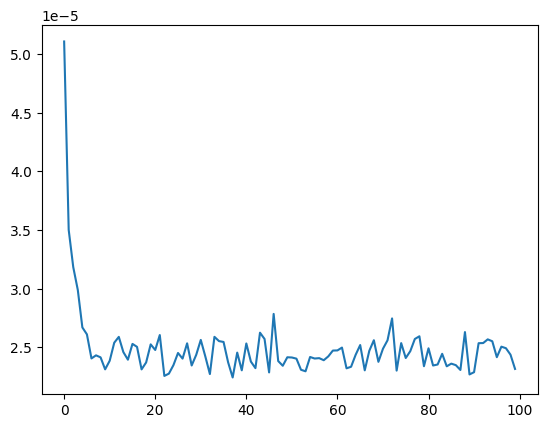

In [9]:
with open(results_dir + "final_results.pkl", "rb") as file:
    final_results  = pickle.load(file)

train_loss_hist = final_results['train_loss_hist']
val_loss_hist = final_results['val_loss_hist']
aux_results = final_results['aux_results']

import matplotlib.pyplot as plt

plt.plot(val_loss_hist)

print(np.array(train_loss_hist).max())
print(np.array(train_loss_hist).min())

print(np.array(val_loss_hist).max())
print(np.array(val_loss_hist).min())

# print(train_loss_hist)
# print(val_loss_hist)

# test_loss = test_loss_compute(
#     S_test,
#     phi_mat,
#     A_tilde,
#     batch_phi_bar_opt, 
#     U_r,
#     library_functions,
#     A_hat,
#     selected_indices_spt
# )


In [ ]:
# print(len(preserved_grads)) 
# print(preserved_grads[0]['encoder']['logits'].shape) # (20, 60)

# print(preserved_grads[-1].shape)

100
(20, 60)


In [36]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.traverse_util import flatten_dict, unflatten_dict
import optax  # optional, for global_norm

# 1) Stack every leaf on a new axis=0  -> shapes become (T, ...)
stacked = jax.tree.map(lambda *xs: jnp.stack(xs, axis=0), *preserved_grads)
# print(stacked['params']['final_layer']['kernel'].shape)

# print(preserved_grads[0]['encoder'])

# print(type(preserved_grads[0])) # <class 'numpy.ndarray'>

# print(preserved_grads[0]['encoder'])

# first_grad_tree = preserved_grads[0]          # This should be a dict-like structure
# print(first_grad_tree.shape) # ()

# print(first_grad_tree)



In [45]:
# print(stacked['encoder']['logits'].shape) # (100, 20, 60)
# print(stacked['encoder']['logits'][])
for i in range(stacked['encoder']['logits'].shape[0]):
    print(i, ":", stacked['encoder']['logits'][i].min(), ":",  stacked['encoder']['logits'][i].max())

0 : -0.001709696 : 0.0020706407
1 : -0.0024143737 : 0.0023757066
2 : -0.0013132276 : 0.0011477718
3 : -0.0015773992 : 0.0014042563
4 : -0.00019745246 : 0.00017855676
5 : -2.1199249e-07 : 7.6977364e-07
6 : -0.00022590968 : 0.00021796569
7 : -0.0007867911 : 0.00055907184
8 : -9.109868e-05 : 6.764428e-05
9 : -0.005311109 : 0.0035401697
10 : -0.0011276274 : 0.0010172053
11 : -0.0039325953 : 0.008638916
12 : -7.1992006e-05 : 8.1413564e-05
13 : -0.0006350095 : 0.00053412403
14 : -0.00015782095 : 0.00014352055
15 : -5.0071572e-05 : 2.6750908e-05
16 : 0.0 : 0.0
17 : 0.0 : 0.0
18 : 0.0 : 0.0
19 : 0.0 : 0.0
20 : 0.0 : 0.0
21 : 0.0 : 0.0
22 : 0.0 : 0.0
23 : 0.0 : 0.0
24 : 0.0 : 0.0
25 : 0.0 : 0.0
26 : 0.0 : 0.0
27 : 0.0 : 0.0
28 : 0.0 : 0.0
29 : 0.0 : 0.0
30 : 0.0 : 0.0
31 : 0.0 : 0.0
32 : 0.0 : 0.0
33 : 0.0 : 0.0
34 : 0.0 : 0.0
35 : 0.0 : 0.0
36 : 0.0 : 0.0
37 : 0.0 : 0.0
38 : 0.0 : 0.0
39 : 0.0 : 0.0
40 : 0.0 : 0.0
41 : 0.0 : 0.0
42 : 0.0 : 0.0
43 : 0.0 : 0.0
44 : 0.0 : 0.0
45 : 0.0 : 0.0
46 : 

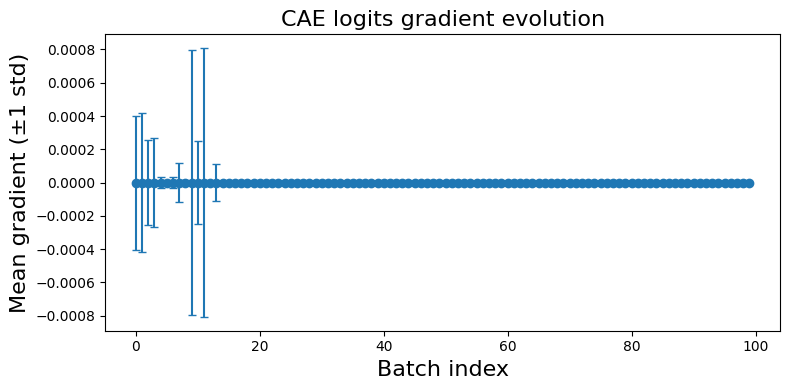

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# def extract_param_list(grads, key_path):
#     """
#     Walk each batch dict along key_path and return a list of numpy arrays.
#     key_path should be something like ['params','final_layer','kernel'].
#     """
    
#     out = []
#     for batch in grads:
#         d = batch
#         for k in key_path:
#             d = d[k]
#         # d is now a JAX Array (or np.ndarray); convert to numpy
#         arr = np.array(d)  
#         out.append(arr)
#     return out

kernels = stacked['encoder']['logits'] # (, 5,1)

means = [arr.mean() for arr in kernels]
stds  = [arr.std()  for arr in kernels]

all_idxs = np.arange(len(means))
sampled_idxs = all_idxs           # 0, 10, 20, …
sampled_means = np.array(means)
sampled_stds  = np.array(stds)
plt.figure(figsize=(8,4))
plt.errorbar(
    sampled_idxs,
    sampled_means,
    yerr=sampled_stds,
    fmt='o',
    capsize=3
)

plt.xlabel('Batch index', fontsize=16)
plt.ylabel('Mean gradient (±1 std)', fontsize=16)
plt.title('CAE logits gradient evolution', fontsize=16)
plt.tight_layout()
plt.show()  

In [9]:
# print(preserved_sum_batch_grads[881]['params']['final_layer']['kernel'])

4900
nan


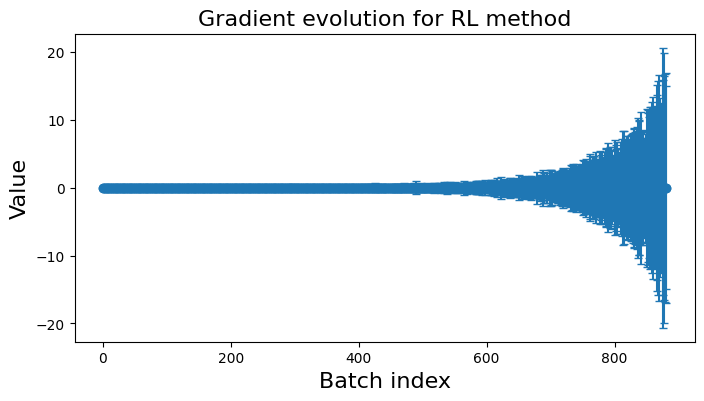

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def extract_param_list(grads, key_path):
    """
    Walk each batch dict along key_path and return a list of numpy arrays.
    key_path should be something like ['params','final_layer','kernel'].
    """
    
    out = []
    for batch in grads:
        d = batch
        for k in key_path:
            d = d[k]
        # d is now a JAX Array (or np.ndarray); convert to numpy
        arr = np.array(d)  
        out.append(arr)
    return out


# kernels = stacked['params']['layer_0']['net1']['kernel'] # (, 5,8)
# kernels = stacked['params']['layer_0']['net2']['kernel'] # (, 8,5)
# kernels = stacked['params']['layer_1']['net1']['kernel'] # (, 5,8)
# kernels = stacked['params']['layer_1']['net2']['kernel'] # (, 8,5)
kernels = stacked['params']['final_layer']['kernel'] # (, 5,1)

means = [arr.mean() for arr in kernels]
stds  = [arr.std()  for arr in kernels]

# import matplotlib.pyplot as plt
# plt.errorbar(np.arange(len(means)), means, yerr=stds, fmt='o', capsize=3)
# plt.xlabel('Batch index', fontsize = 16)
# plt.ylabel('Mean gradient (±1 std)', fontsize = 16)
# plt.title('REINFORCE gradient variance of final layer', fontsize = 16)
# plt.show()

# print(len(means)) # 3100

all_idxs = np.arange(len(means))

# sampled_idxs = all_idxs[::10]           # 0, 10, 20, …
# sampled_means = np.array(means)[::10]
# sampled_stds  = np.array(stds)[::10]

sampled_idxs = all_idxs          
sampled_means = np.array(means)
sampled_stds  = np.array(stds)


plt.figure(figsize=(8,4))

# plt.errorbar(
#     sampled_idxs[-100:],
#     sampled_means[-100:],
#     yerr=sampled_stds[-100:],
#     fmt='o',
#     capsize=3
# )


# print(sampled_means[881])

print(len(sampled_means))

plt.errorbar(
    sampled_idxs[:890],
    sampled_means[:890],
    yerr=sampled_stds[:890],
    fmt='o',
    capsize=3
)
plt.xlabel('Batch index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Gradient evolution for RL method', fontsize = 16)

print(sampled_means[882])

# plt.xticks(sampled_idxs)                     
# plt.xlabel('Batch index', fontsize=16)
# plt.ylabel('Mean gradient (±1 std)', fontsize=16)
# plt.title('REINFORCE gradient variance of final layer', fontsize=16)
# plt.tight_layout()
# plt.show()  

# no bias in the network:
# test = stacked['params']['layer_0']['net1']['kernel'] # (, 5,8)
# test = stacked['params']['layer_0']['net2']['kernel'] # (, 8,5)
# test = stacked['params']['layer_1']['net1']['kernel'] # (, 5,8)
# test = stacked['params']['layer_1']['net2']['kernel'] # (, 8,5)
# test = stacked['params']['final_layer']['kernel'] # (, 5,1)

In [11]:
# print(preserved_sum_batch_grads[226])
# print(adv_vals[225])

# print(len(adv_vals), adv_vals[0].shape)
# adv_vals_array = np.array(adv_vals[:225])

min_adv_vals = []
for i in range(len(adv_vals)):
    min_adv_vals.append(np.min(adv_vals[i]).item())
    # print(adv_vals[i].shape)

# print(len(min_adv_vals))

plt.plot(min_adv_vals)


# plt.plot(min_adv_vals)
# print(min_adv_vals[220:230])


NameError: name 'adv_vals' is not defined

In [12]:
lr_mod_vals = lrs_sample_rewards['modified_learning_rates']
# print(lr_mod_vals[220: 230])
# plt.plot(lr_mod_vals[:226])

print(lr_mod_vals[226])
print(min_adv_vals[226])
        

0.0010000183


IndexError: list index out of range

In [13]:
print(preserved_sum_batch_grads[0])

{'params': {'final_layer': {'bias': Array([-0.56258327, -0.08541098,  0.40303516, -0.50420487,  0.05581415,
        0.69334966], dtype=float32), 'kernel': Array([[-0.05248371,  0.14782184, -0.15892501,  0.16243729,  0.23511392,
        -0.33396423],
       [-0.00708514,  0.05587257, -0.07791313,  0.07343077,  0.11771537,
        -0.16202039],
       [ 0.01542244, -0.12476443,  0.02251478, -0.12060768,  0.1857646 ,
         0.0216703 ]], dtype=float32)}, 'layer_0': {'net1': {'bias': Array([-0.13690439, -0.487271  , -0.5297236 ], dtype=float32), 'kernel': Array([[ 0.1113868 ,  0.27899992,  0.43028492],
       [ 0.07590501, -0.46702525, -0.5314408 ],
       [-0.21280938, -0.02024579,  0.00171721],
       [-0.24829118, -0.76627094, -0.9600085 ]], dtype=float32)}, 'net2': {'bias': Array([-0.08096355,  1.2039666 ,  0.4344187 ], dtype=float32), 'kernel': Array([[ 0.06363208, -0.14582643,  0.09429334],
       [-0.06083385,  0.44009915, -0.29897326],
       [ 0.11488531, -0.38709983, -0.0554354

In [14]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.traverse_util import flatten_dict
import optax  # only for global_norm plots (pip install optax)

stacked = jax.tree.map(lambda *xs: jnp.stack(xs, axis=0), *[preserved_sum_batch_grads[:3]])  # each leaf: (T, ...)

# mean_tree = jax.tree.map(lambda x: jnp.mean(x, axis=0), stacked)
# var_tree  = jax.tree.map(lambda x: jnp.var(x,  axis=0), stacked)
# std_tree  = jax.tree.map(jnp.sqrt, var_tree)

# print(stacked[0],'\n________\n', mean_tree[0])
# tv1 = stacked[0]['params']['final_layer']['kernel'] # dict_keys(['final_layer', 'layer_0', 'layer_1'])
# tv2 = mean_tree[0]['params']['final_layer']['kernel']
# print(np.allclose( stacked[0]['params']['layer_0']['net1']['kernel'],   mean_tree[0]['params']['layer_0']['net1']['kernel']    ))
# print(stacked[0]['params'].keys())
# print(np.allclose(tv1, tv2))

# print(stacked[0])
print(stacked[0])

# var_kernel = var_tree['params']['final_layer']['kernel']

# plt.figure(figsize=(4,3))

# if var_kernel.ndim == 1:
#     plt.plot(var_kernel, marker='o')
#     plt.ylabel("Var(∂L/∂kernel)")
# elif var_kernel.ndim == 2:
#     im = plt.imshow(var_kernel, aspect='auto')
#     plt.colorbar(im, label="Var(∂L/∂kernel)")
#     plt.ylabel("output dim")
#     plt.xlabel("input dim")
# else:
#     raise ValueError(f"unexpected ndim {var_kernel.ndim}")

# plt.title("Variance of grads: params/final_layer/kernel")
# plt.tight_layout()
# plt.show()


{'params': {'final_layer': {'bias': Array([[-0.56258327, -0.08541098,  0.40303516, -0.50420487,  0.05581415,
         0.69334966]], dtype=float32), 'kernel': Array([[[-0.05248371,  0.14782184, -0.15892501,  0.16243729,
          0.23511392, -0.33396423],
        [-0.00708514,  0.05587257, -0.07791313,  0.07343077,
          0.11771537, -0.16202039],
        [ 0.01542244, -0.12476443,  0.02251478, -0.12060768,
          0.1857646 ,  0.0216703 ]]], dtype=float32)}, 'layer_0': {'net1': {'bias': Array([[-0.13690439, -0.487271  , -0.5297236 ]], dtype=float32), 'kernel': Array([[[ 0.1113868 ,  0.27899992,  0.43028492],
        [ 0.07590501, -0.46702525, -0.5314408 ],
        [-0.21280938, -0.02024579,  0.00171721],
        [-0.24829118, -0.76627094, -0.9600085 ]]], dtype=float32)}, 'net2': {'bias': Array([[-0.08096355,  1.2039666 ,  0.4344187 ]], dtype=float32), 'kernel': Array([[[ 0.06363208, -0.14582643,  0.09429334],
        [-0.06083385,  0.44009915, -0.29897326],
        [ 0.11488531, -

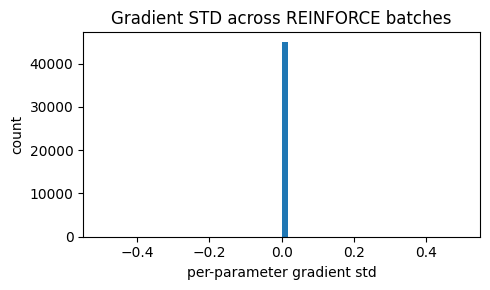

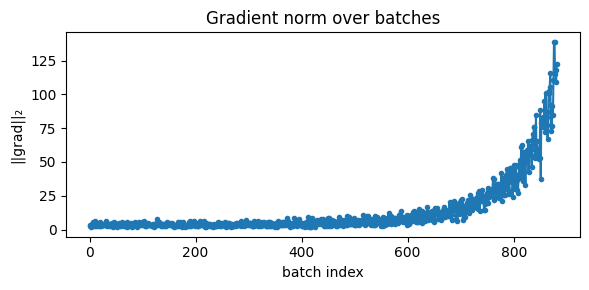


Top-variance param blocks:
('params', 'final_layer', 'bias') nan
('params', 'final_layer', 'kernel') nan
('params', 'layer_0', 'net1', 'bias') nan
('params', 'layer_0', 'net1', 'kernel') nan
('params', 'layer_0', 'net2', 'bias') nan


TypeError: list indices must be integers or slices, not str

In [15]:
# plotting the variance in the gradient values over each successive batch:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.traverse_util import flatten_dict
import optax  # only for global_norm plots (pip install optax)

stacked = jax.tree.map(lambda *xs: jnp.stack(xs, axis=0), *[preserved_sum_batch_grads])  # each leaf: (T, ...)

# ---------- 2) Mean / Var / Std across batches ----------
mean_tree = jax.tree.map(lambda x: jnp.mean(x, axis=0), stacked)
var_tree  = jax.tree.map(lambda x: jnp.var(x,  axis=0), stacked)
std_tree  = jax.tree.map(jnp.sqrt, var_tree)

# ---------- 3) Flatten to a vector for global histogram ----------
def tree_to_vec(tree):
    leaves, _ = jax.tree_util.tree_flatten(tree)
    return jnp.concatenate([l.ravel() for l in leaves], axis=0)

std_vec = np.array(tree_to_vec(std_tree))

plt.figure(figsize=(5,3))
plt.hist(std_vec, bins=60)
plt.xlabel("per-parameter gradient std")
plt.ylabel("count")
plt.title("Gradient STD across REINFORCE batches")
plt.tight_layout(); plt.show()

# ---------- 4) Gradient L2 norm per batch (time series) ----------
l2_norms = np.array([optax.global_norm(g) for g in preserved_sum_batch_grads])
plt.figure(figsize=(6,3))
plt.plot(l2_norms, marker='.')
plt.xlabel("batch index")
plt.ylabel("||grad||₂")
plt.title("Gradient norm over batches")
plt.tight_layout(); plt.show()

# ---------- 5) Per-leaf (layer/tensor) variance summary ----------
flat0 = flatten_dict(preserved_sum_batch_grads[0])  # tuple keys -> arrays
per_leaf_std = {}
for k in flat0.keys():
    arrs = [flatten_dict(g)[k].ravel() for g in preserved_sum_batch_grads]
    arrs = np.stack(arrs, axis=0)           # (T, P_leaf)
    per_leaf_std[k] = arrs.std(axis=0).mean()

print("\nTop-variance param blocks:")
for k, v in sorted(per_leaf_std.items(), key=lambda kv: -kv[1])[:5]:
    print(k, f"{v:.4e}")

# ---------- 6) Example heatmap of one kernel’s std ----------
# edit key to match your tree (use print(flat0.keys()) to see options)
leaf_key = ('params','layer_0','net1','kernel')
kernel_std = std_tree['params']['layer_0']['net1']['kernel']
plt.figure(figsize=(4,3))
plt.imshow(np.array(kernel_std), aspect='auto')
plt.colorbar(label='std')
plt.title('Std of layer_0/net1/kernel grads')
plt.tight_layout(); plt.show()

In [16]:
# print(preserved_sum_batch_grads[347])
# check the working of the model too, implement validation dataset to track losses. 
# print(preserved_sum_batch_grads[3])

In [17]:
# print(S_test.shape)
best_sample_list = final_results['best_sample_list']
# print(len(best_sample_list)) # 100

print(best_sample_list[0].keys())

best_err_sample = min(best_sample_list, key=lambda d: d['reconstr_err'])

best_reward_sample = max(best_sample_list, key=lambda d: d['sample_reward'])


dict_keys(['selection_arr', 'probability_arr', 'reconstr_err', 'sample_reward'])


In [ ]:
# print(best_err_sample['selection_arr'])

# plots to make
# 1. testing error plot using the best sample -lowest reconstr_err
# 2. testing error plot using the best sample -highest sample reward
# 3. batch_reward_values
# 4. 



[1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1]


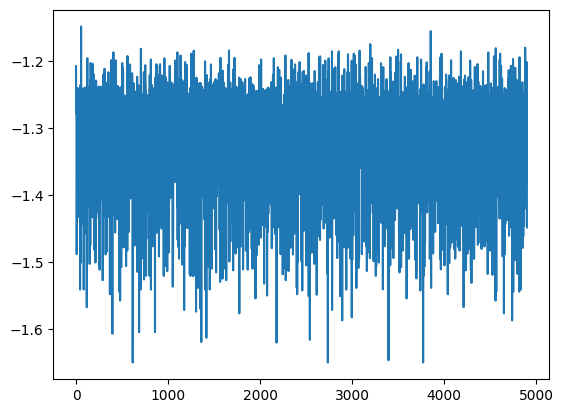

In [18]:
plt.plot(final_results['batch_reward_list'])